In [55]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd 

In [56]:
# Q1: reading and formatting dataset 

# Q1.1: read German credit dataset 
dataset = pd.read_csv('GermanCredit.txt', delim_whitespace = True, header = None)
dataset.shape

# Q1.2: credit risk data 
m = 800 
n = 200
ytrain = np.array(dataset.iloc[0:m,-1]) - 1
ytest = np.array(dataset.iloc[m:(m+n),-1]) - 1

# Q1.3: center and scale features 
xdata = np.array(dataset.iloc[:, 0:24])
xdata = (xdata - np.mean(xdata, axis = 0)) / np.std(xdata, axis = 0)
xtrain = xdata[0:m, :]
xtest = xdata[m:(m+n), :]

# Q1.4 add a column of ones 
xtrain = np.concatenate((np.ones([m, 1]), xtrain), axis = 1)
xtest = np.concatenate((np.ones([n, 1]), xtest), axis = 1)

# dimension
D = 25

In [ ]:
# install jax package
import sys
!{sys.executable} -m pip install jax 

In [57]:
# Q5 write log-likelihood function in numpy 
def loglikelihood_numpy(beta):
    x_beta = np.matmul(xtrain, beta)
    output = np.sum(ytrain * x_beta - np.log(1 + np.exp(x_beta)))
    return output

# simulate regression coeff
beta = np.random.randn(D)  
print(loglikelihood_numpy(beta))


-2246.502872737364


In [58]:
import jax.numpy as jnp
from jax import jit

# write log-likelihood function in a JAX-compatiable way
@jit
def loglikelihood_jax(beta):
    x_beta = jnp.matmul(xtrain, beta)
    output = jnp.sum(ytrain * x_beta - jnp.log(1 + jnp.exp(x_beta)))
    return output

# check that we get the same result as the numpy implementation
print(loglikelihood_jax(beta))

# there is no point using JIT for the log-likelihood
jit_loglikelihood_jax = jit(loglikelihood_jax)

import time
%timeit jit_loglikelihood_jax(beta) # timing with JIT 
%timeit loglikelihood_jax(beta) # timing without JIT

# use the implementation without JIT
loglikelihood = loglikelihood_jax


-2246.5027
36.4 µs ± 2.51 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)
44.9 µs ± 9.38 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [59]:
# Q6: auto-diff to get the gradient of the log-likelihood
from jax import grad
gradloglikelihood1 = grad(loglikelihood_jax) # without JIT
gradloglikelihood2 = jit(grad(loglikelihood_jax)) # with JIT 

# for the gradient, there is a signfiicant speedup with JIT
%timeit gradloglikelihood1(beta)
%timeit gradloglikelihood2(beta)

# use the faster implementation
gradloglikelihood = jit(grad(loglikelihood_jax))

1.99 ms ± 459 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)
38.7 µs ± 3.93 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [60]:
# Q7: prior density
constant = np.pi**2 * m / (3 * D)
Sigma = constant * np.linalg.inv(np.matmul(xtrain.transpose(), xtrain))

from jax.scipy.stats import multivariate_normal

@jit
def logprior(beta):
    return multivariate_normal.logpdf(beta, mean = jnp.zeros(D), cov = Sigma)


In [62]:
# Q8: gradient of log-prior density
gradlogprior1 = jit(grad(logprior))
gradlogprior2 = grad(logprior)

%timeit gradlogprior1(beta)
%timeit gradlogprior2(beta)

# use JIT because it is faster
gradlogprior = jit(grad(logprior))


36.4 µs ± 3.51 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)
1.63 ms ± 108 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [65]:
# Q9: log-unnormalized posterior density
def logdensity(beta):
    return logprior(beta) + loglikelihood(beta)

# Q10: gradient of log-unnormalized posterior density
def gradlogdensity(beta):
    return gradlogprior(beta) + gradloglikelihood(beta)


In [76]:
# Section 3
# Q1: independent Metropolis-Hastings
import scipy

def sample_prior():
    return scipy.stats.multivariate_normal.rvs(mean = np.zeros(D), cov = Sigma)


# initialize the Markov chain
beta = sample_prior()

N = 10000
store_beta = np.zeros((N, D))
num_accept = 0 
for n in range(N):
    # 1) sample proposed state
    proposed_state = sample_prior()

    # 2) evaluate posterior densities
    logdensity_proposed = logdensity(proposed_state)
    logdensity_current = logdensity(beta)

    # 3) evaluate prior densities
    logprior_proposed = logprior(proposed_state)
    logprior_beta = logprior(beta)

    # 4) log-acceptance prob
    logacceptprob = float(logdensity_proposed + logprior_beta - logdensity_current - logprior_proposed)

    # 5) accept or reject
    uniform = np.random.rand(1) # sample a uniform on [0,1]
    if np.log(uniform) < logacceptprob:
        beta = proposed_state.copy() # accepting 
        num_accept += 1

    # 6) store states 
    store_beta[n,:] = beta


In [67]:
# acceptance rate
num_accept / N 

0.0008

Text(0, 0.5, 'beta0')

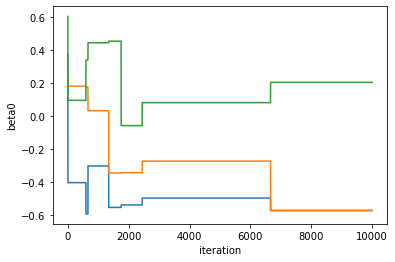

In [71]:
# trace plot
iteration = np.arange(1, N+1)
plt.figure()
plt.plot(iteration, store_beta[:,0])
plt.plot(iteration, store_beta[:,1])
plt.plot(iteration, store_beta[:,2])
plt.xlabel('iteration')
plt.ylabel('beta0')

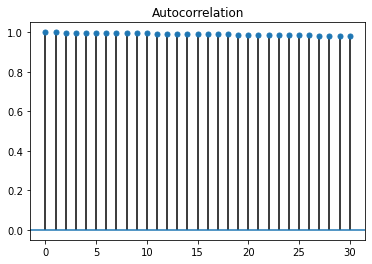

<Figure size 432x288 with 0 Axes>

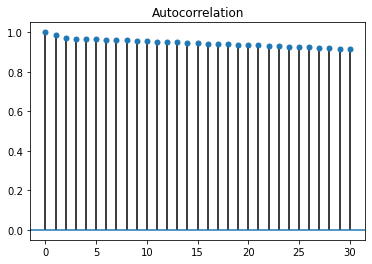

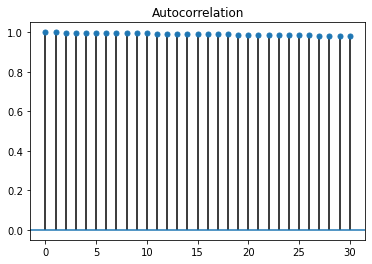

In [75]:
# auto-correlation function
from statsmodels.graphics.tsaplots import plot_acf

plt.figure()
plot_acf(store_beta[:,0], lags = 30, alpha = None)
plot_acf(store_beta[:,1], lags = 30, alpha = None)